# Συνελικτικά Νευρωνικά Δίκτυα

Περιέχει υλικό από την τεκμηρίωση του [TensorFlow](https://www.tensorflow.org/) και το βιβλίο του 
Michael Nielsen [Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/).

---

> Πάνος Λουρίδας, Αναπληρωτής Καθηγητής <br />
> Τμήμα Διοικητικής Επιστήμης και Τεχνολογίας <br />
> Οικονομικό Πανεπιστήμιο Αθηνών <br />
> louridas@aueb.gr

In [1]:
import tensorflow as tf
from keras import datasets, layers, models

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from scipy import signal

from PIL import Image

tf.random.set_seed(0)

* Πριν ξεκινήσουμε με τα νευρωνικά δίκτυα που θα εξετάσουμε, ας δούμε τι είναι στην πραγματικότητα ένα φίλτρο που εφαρμόζουμε σε μία εικόνα.

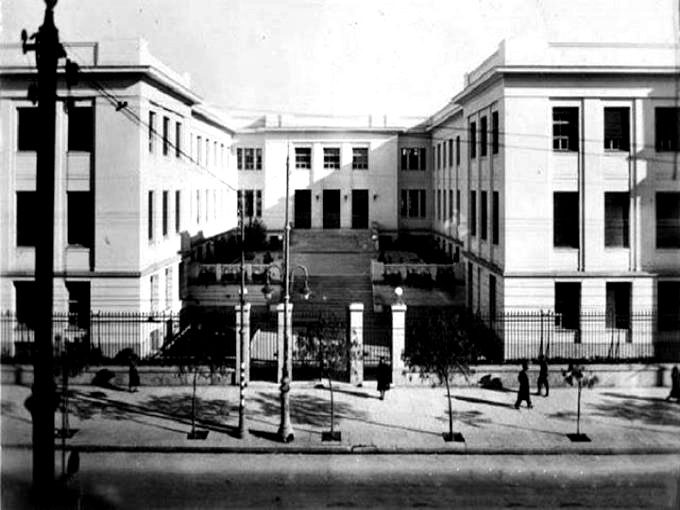

In [2]:
img = Image.open('aueb_1940_bw.jpg')

display(img)

* Θα πάρουμε τα περιεχόμενα της εικόνας ως πίνακα.

In [3]:
img_data = np.array(img)
img_data

array([[232, 230, 233, ..., 235, 205, 151],
       [243, 234, 228, ..., 234, 204, 151],
       [255, 239, 224, ..., 233, 202, 149],
       ...,
       [131,  74,  61, ...,  56,  51,  43],
       [134,  77,  63, ...,  56,  52,  44],
       [136,  78,  64, ...,  56,  52,  44]], dtype=uint8)

* Θα τα μετατρέψουμε ώστε οι τιμές του πίνακα να είναι μεταξύ του 0 και του 1.

In [4]:
print(img_data.shape)
print(np.max(img_data))
img_data = img_data / np.max(img_data)

(510, 680)
255


* Ιδού πώς είναι η εικόνα μας τώρα:

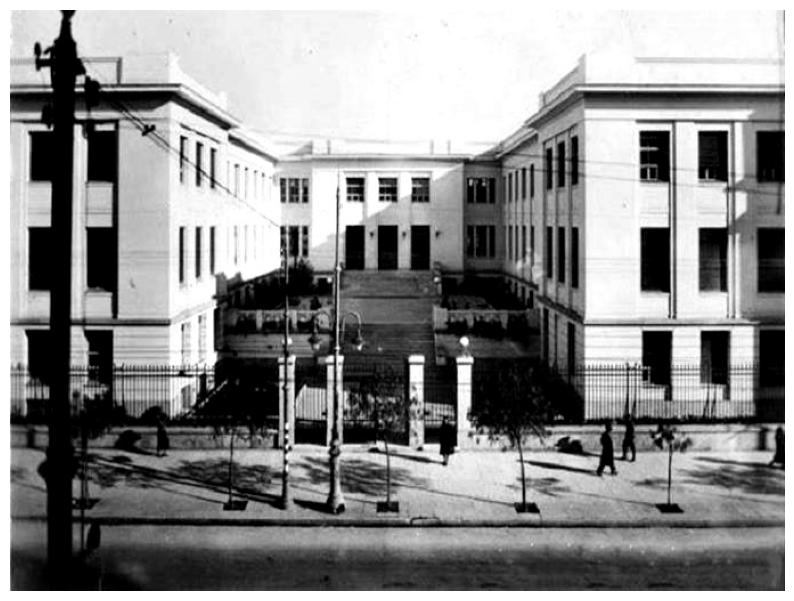

In [5]:
plt.figure(figsize=(10, 10))
plt.axis('off')
_ = plt.imshow(img_data, norm=matplotlib.colors.Normalize(0, 1), cmap='gray')

* Ένα φίλτρο που εφαρμόζουμε σε μία εικόνα είναι απλώς ένας πίνακας με αριθμούς.

* Τον πίνακα αυτόν τον σέρνουμε πάνω στην εικόνα και σε κάθε σημείο υπολογίζουμε το άθροισμα των γινομένων των στοιχείων του φίλτρου με τα αντίστοιχα στοιχεία του πίνακα των περιεχομένων της εικόνας.

* Η πράξη αυτή ονομάζεται *συνέλιξη* (convolution).

* Στη συνέχεια βλέπουμε τι γίνεται αν εφαρμόσουμε στην εικόνα ένα φίλτρο το οποίο αναδεικνύει τις ακμές στην εικόνα μας.

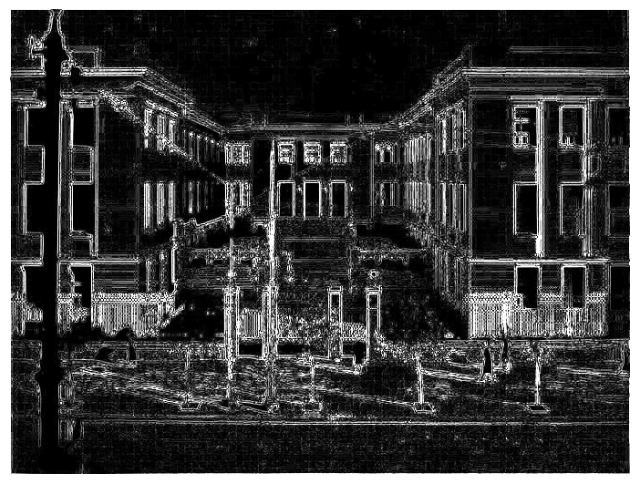

In [6]:
em = np.array([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1]
])
edges = signal.convolve2d(img_data, em, boundary='fill', mode='same')
plt.figure(figsize=(8, 8))
plt.axis('off')
_ = plt.imshow(np.absolute(edges), norm=matplotlib.colors.Normalize(0, 1), cmap='gray')

* Με άλλου είδους φίλτρα (πίνακες) μπορούμε να εξάγουμε άλλου είδους χαρακτηριστικά από μία εικόνα.

* Επομένως, για να εξάγουμε πληροφορία από μία εικόνα, μπορούμε να αναζητήσουμε τα καταλληλότερα φίλτρα που θα εφαρμόσουμε σε αυτήν.

* Ποια θα είναι αυτά τα φίλτρα;

* Θα μας τα βρει ένα νευρωνικό δίκτυο.

* Μέχρι τώρα χρησιμοποιούσαμε νευρωνικά δίκτυα στα οποία όλοι οι νευρώνες συνδέονταν με τους νευρώνες του προηγούμενου στρώματος.

* Αυτό όμως δεν είναι απαραίτητο.

* Μπορούμε να χρησιμοποιήσουμε μια αρχιτεκτονική η οποία να ταιριάζει περισσότερο στη φύση του προβλήματός μας.

* Μια τέτοια αρχιτεκτονική είναι τα Συνελικτικά Νευρωνικά Δίκτυα (Convolutional Neural Networks, CNNs), τα οποία έχουν γνωρίσει ιδιαίτερη επιτυχία σε εφαρμογές αναγνώρισης εικόνας.

* Σε ένα Συνελικτικό Νευρωνικό Δίκτυο, η διάταξη των νευρώνων στο στρώμα εισόδου αντιστοιχεί στις διαστάσεις των εικόνων μας. 

* Έτσι, αν έχουμε εικόνες διαστάσεων $28\times 28$, οι νευρώνες θα βρίσκονται σε μία διάταξη $28\times 28$.

* Στη συνέχεια θα συνδέσουμε τους νευρώνες στο στρώμα εισόδου με τους νευρώνες του πρώτου κρυμμένου στρώματος.

* Δεν θα συνδέσουμε όλους τους νευρώνες του στρώματος εισόδου με κάθε νευρώνα του κρυμμένου στρώματος.

* Θα συνδέσουμε μόνο τους νευρώνες ενός μικρού τμήματος της εικόνας.

* Για παράδειγμα, μπορεί κάθε νευρώνας του πρώτου κρυμμένου στρώματος να συνδέεται με μία περιοχή $5\times 5$ της αρχικής εικόνας.

* Αυτή η περιοχή ονομάζεται *τοπικό αισθητήριο πεδίο* (local receptive field) του νευρώνα.

* Όπως βλέπουμε προχωράμε από τα αριστερά στα δεξιά, και επίσης από πάνω προς τα κάτω.

* Στο παράδειγμα προχωράμε ένα pixel κάθε φορά.

* Αυτό δεν είναι απαραίτητο.

* Ο αριθμός των pixel που προχωράμε κάθε φορά ονομάζεται *δρασκελιά* (stride).

* Κάθε νευρώνας δρα ως φίλτρο στο τοπικό αισθητήριο πεδίο του.

* Γιατί; Διότι υπολογίζει το άθροισμα των γινομένων των βαρών του (πίνακας) με το αισθητήριο πεδίο του.

* Για να δράσει ως φίλτρο σε όλη την εικόνα, θα πρέπει με κάποιον τρόπο να καλύψει όλη την εικόνα (σαν να σύρουμε τον νευρώνα επάνω της).

* Αυτό είναι ισοδύναμο με το να *μοιράζονται* όλοι οι νευρώνες του στρώματος τα ίδια βάρη και πολώσεις.

* Αυτό ονομάζεται *διαμοιρασμός παραμέτρων* (parameter sharing).

* Επιπλέον, δεν χρειάζεται να έχουμε μόνο ένα σύνολο νευρώνων που δρα ως φίλτρο στο στρώμα.

* Μπορούμε να έχουμε περισσότερα.

* Με τον τρόπο αυτό, μπορούμε να έχουμε ένα σύνολο φίλτρων που θέλουμε να εφαρμόσουμε στην εικόνα.

* Αλλά τι φίλτρα είναι αυτά; Τι εντοπίζουν;

* Δεν ξέρουμε εκ των προτέρων! Αυτό θα προκύψει από τη διαδικασία της εκπαίδευσης.

* Εκτός από συνελικτικά στρώματα, στα Συνελικτικά Νευρωνικά Δίκτυα χρησιμοποιούμε επίσης *στρώματα συγκέντρωσης* (pooling layers).

* Ένα συγκεντρωτικό στρώμα ελαττώνει το μέγεθος του προηγούμενου στρώματος. Στην ουσία, το συμπυκνώνει.

* Για παράδειγμα, ένας νευρώνας στο στρώμα συγκέντρωσης μπορεί να παίρνει μια περιοχή $2\times 2$ του προηγούμενου στρώματος και να παράγει μια τιμή από αυτά, όπως το μέσο όρο ή τη μέγιστη τιμή.

* Θα ακολουθήσουμε το [παράδειγμα που δίνει το TensorFlow για την ταξινόμηση εικόνων](https://www.tensorflow.org/tutorials/images/cnn).

* Το σύνολο δεδομένων [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) αποτελείται από 60.000 έγχρωμες εικόνες διαστάσεων $32 \times 32$.

* Οι εικόνες ανήκουν σε 10 κλάσεις, με 6000 εικόνες ανά κλάση. 

* Υπάρχουν 50.000 εικόνες εκπαίδευσης και 10.000 εικόνες ελέγχου.

In [7]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

* Για να πάρουμε μια ιδέα πώς είναι οι εικόνες, θα πάρουμε τις πρώτες 25 από αυτές.

* θα γράψουμε μια βοηθητική συνάρτηση για το σκοπό αυτό.

In [8]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

def display_cifar(rows, cols):

    plt.figure(figsize=(10,10))
    for i in range(rows * cols):
        plt.subplot(rows, cols, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(train_images[i], cmap=plt.cm.binary)
        # The CIFAR labels happen to be arrays, 
        # which is why you need the extra index
        plt.xlabel(class_names[train_labels[i][0]])

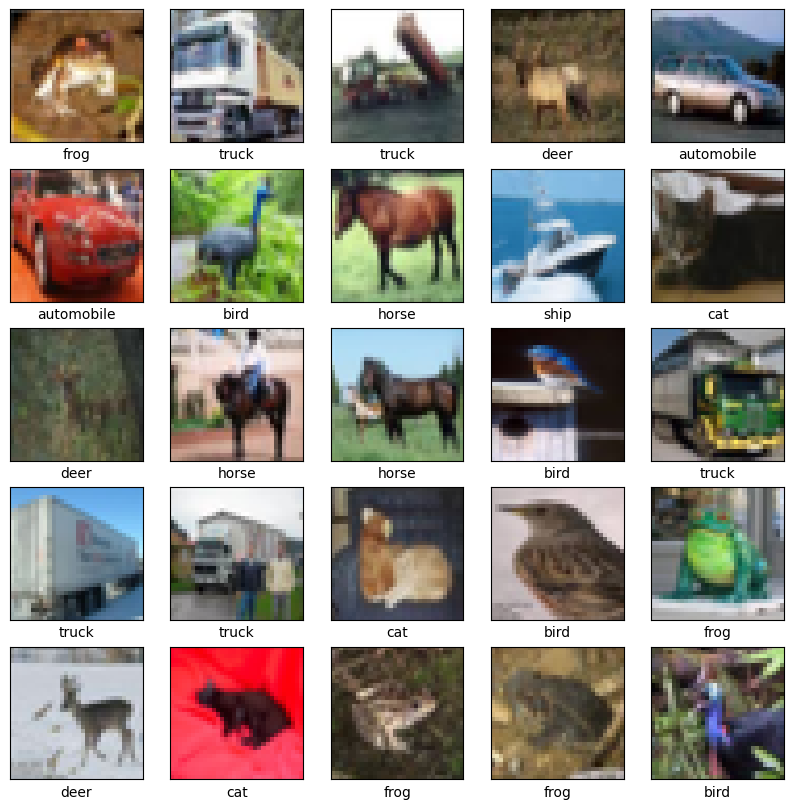

In [9]:
display_cifar(5, 5)

* Θα φτιάξουμε μια συνελικτική βάση που θα αποτελείται από μία σειρά στρωμάτων `Conv2D` και `MaxPooling2D`.

* Η είοσδος στο νευρωνικό δίκτυο θα είναι $32 \times 32 \times 3$, αφού έχουμε τρία χρώματα.

* Θα έχουμε ένα στρώμα `Rescaling` στην αρχή, το οποίο θα εξασφαλίζει ότι οι τιμές σε κάθε εικόνα είναι μεταξύ του 0 και του 1.

In [10]:
model = models.Sequential()
model.add(layers.Input(shape=(32, 32, 3)))
model.add(layers.Rescaling(1./255))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

* Συνοπτικά:

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 64)            │          36,928 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,320 (220.00 KB)

 Trainable params: 56,320 (220.00 KB)

 Non-trainable params: 0 (0.00 B)

* Το πρώτο συνελικτικό στρώμα περιέχει 32 φίλτρα, το κάθε ένα από τα οποία είναι διαστάσεων $3 \times 3$. Η έξοδος είναι `(30, 30, 32)`, αφού αν το σκεφτούμε ένα φίλτρο $3 \times 3$ χωράει 30 φορές οριζόντια και κάθετα σε μία εικόνα $32 \times 32$.

* Το στρώμα `MaxPooling2D` θα μειώσει στο μισό τις διαστάσεις, σε `(15, 15, 32)`

* Το δέυτερο συνελικτικό στρώμα περιέχει 64 φίλτρα, το κάθε ένα διαστάσεων $3 \times 3$.

* Έτσι η έξοδός του θα είναι διαστάσεων `(13, 13, 64)`.

* Το δεύτερο στρώμα `MaxPooling2D` θα μειώσει τις διαστάσεις σε `(6, 6, 64)`.

* Το τελευταίο συνελικτικό στρώμα θα έχει έξοδο `(4, 4, 64)`.

* Στη συνέχεια θα μετατρέψουμε το `(4, 4, 64)` σε έναν μονοδιάστατο πίνακα διαστάσεων $4 \times 4 \times 64 = 1024$.

* Το αποτέλεσμα θα το περάσουμε από ένα πυκνό στρώμα με 64 νευρώνες, 

* Στο τέλος θα έχουμε ένα στρώμα με 10 νευρώνες, έναν για κάθε κλάση.

In [12]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,570 (478.79 KB)

 Trainable params: 122,570 (478.79 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, 
                    epochs=10, 
                    validation_split=0.2)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.3228 - loss: 1.8168 - val_accuracy: 0.5281 - val_loss: 1.3175
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.5430 - loss: 1.2739 - val_accuracy: 0.6005 - val_loss: 1.1339
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.6153 - loss: 1.0998 - val_accuracy: 0.6426 - val_loss: 1.0250
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.6539 - loss: 0.9884 - val_accuracy: 0.6697 - val_loss: 0.9621
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.6829 - loss: 0.9045 - val_accuracy: 0.6752 - val_loss: 0.9391
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.7045 - loss: 0.8425 - val_accuracy: 0.6790 - val_loss: 0.9430
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.7240 - loss: 0.7905 - val_accuracy: 0.6780 - val_loss: 0.9615
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.7391 -

* Θα πάρουμε την ιστορία για να δούμε πώς βελτιώνεται η απόδοση του δικτύου κατά τη διάρκεια της εκπαίδευσης.

In [14]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,accuracy,loss,val_accuracy,val_loss,epoch
0,0.419950,1.581043,0.5281,1.317499,0
1,0.558375,1.234838,0.6005,1.133913,1
2,0.622250,1.075425,0.6426,1.024951,2
3,0.658800,0.971157,0.6697,0.962097,3
4,0.688200,0.889827,0.6752,0.939121,4
5,0.708975,0.828475,0.6790,0.943033,5
6,0.728825,0.776564,0.6780,0.961456,6
7,0.742000,0.736591,0.6760,0.970893,7
8,0.756600,0.695085,0.6811,0.955988,8
9,0.770925,0.654433,0.6820,0.975598,9


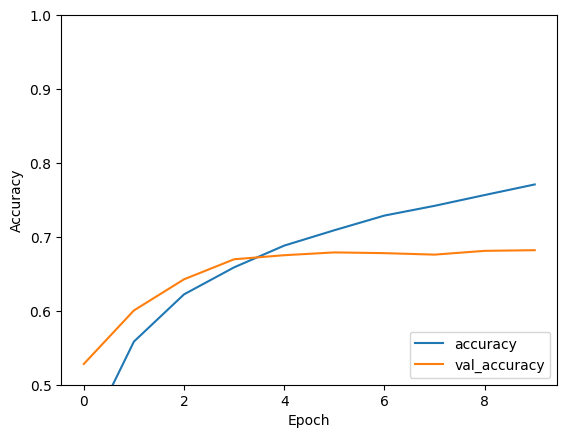

In [15]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

* Επίσης μπορούμε να δούμε την επίδοση του δικτύου στα δεδομένα ελέγχου.

In [16]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print('test loss:', test_loss, 'test accuracy:', test_acc)

313/313 - 2s - 7ms/step - accuracy: 0.6779 - loss: 0.9886
test loss: 0.9885998964309692 test accuracy: 0.6779000163078308


* Τα Συνελικτικά Νευρωνικά Δίκτυα χρησιμοποιούνται πλέον κατά κόρον σε εφαρμογές με εικόνες και βίντεο.

* Στην παραγωγή τα δίκτυα είναι πολύ πιο περίπλοκα, με περισσότερα στρώματα και διασυνδέσεις μεταξύ στρωμάτων, από το απλό παράδειγμα που είδαμε.

* Στην πράξη συχνά χρησιμοποιούμε *προεκπαιδευμένα* νευρωνικά δίκτυα, τα οποία έχουν ήδη εκπαιδευτεί σε μεγάλα σύνολα εικόνων ή βίντεο, και μπορούμε να τα υιοθετήσουμε στις δικές μας εφαρμογές.

* Η ανάπτυξη καλύτερων αρχιτεκτονικών νευρωνικών δικτύων για συγκεκριμένες εφαρμογές είναι ένα πολύ ενεργό ερευνητικό πεδίο.